In [6]:
import requests
import pandas as pd
import json

![Params](nmdc_api_params.png)

GET
/dataset/{startyear}/{cruiseid}/{platform}

In [7]:
def fetch_sensordata(startyear, cruiseid, outname):
    api_url = 'http://underway-api.hi.no/apis/nmdapi/underway/v1'
    r = requests.get(f'{api_url}/dataset/{startyear}/{cruiseid}/9998', headers={"accept":"application/json"})
    with open(f'{outname}.json', 'w', encoding='utf-8') as f:
        json.dump(r.json(), f, ensure_ascii=False, indent=4)

In [8]:
fetch_sensordata(2022, 2022054, 'leg4')

In [11]:
def prep_and_separate_sensorjson(path, leg):
    f = open(path)

    data = json.load(f)

    sensors = data['sensor']
    for sensor in sensors:
        unit = sensor['unit']
        metadata = sensor['custommetadata']
        displayname = metadata[4]
        name = displayname['customvalue']
        data = sensor['timeseriesdata']

        data = { 'unit' : unit, 'sensor' : name, 'data': data }
        json.dumps(data)

        with open(f'{leg}/{name}.json', 'w', encoding='utf-8') as f:
            json.dump(data, f, ensure_ascii=False, indent=4)

In [12]:
prep_and_separate_sensordata('leg4.json', 'Leg4')

## Prepare dataframes

In [49]:
def prep_df(file, prefix):
    f = open(file)
    data = json.load(f)
    name = data['sensor']
    df = pd.json_normalize(data['data'])
    df.dataid = pd.to_datetime(df.dataid, format='%Y-%m-%d %H:%M:%S')
    df = df.set_index('dataid')
    df = df.drop(columns=['sensortimestamp', 'geolocation'])
    df = df.rename(columns={'sensorvalue':name.split(prefix)[1]})
    
    return df


rel_sensors = ['FerryBox.C3_CDOMFluorescence.json', 'FerryBox.C3_Temperature.json', 'FerryBox.C3_CHLAFluorescence.json',
               'FerryBox.C3_Turbidity.json','FerryBox.Optode_Saturation.json', 'FerryBox.SBE45_Conductivity.json', 
               'FerryBox.SBE45_Salinity.json', 'NMEA.Trykk.json', 'NMEA.Humidity.json', 'PCO2.atm_cond.json', 'PCO2.CO2_umm.json',
               'PCO2.H2O_mmm.json']

append_str = 'BlueInsight_'
blueinsight_sensors = [append_str + sub for sub in rel_sensors]

def combine_sensordfs(sensors, leg, prefix):
    prev_df = pd.DataFrame(columns=['dataid']) #empty dataframe with column dataid
    for sensor in sensors:
        df = prep_df(f'{leg}/{sensor}', prefix)
        new_df = pd.merge(df,prev_df,on='dataid', how="outer")
        prev_df = new_df

    return new_df
    

In [50]:
df = combine_sensordfs(blueinsight_sensors, 'Leg4', 'BlueInsight_')

In [44]:
df

,dataid,PCO2.H2O_mmm,PCO2.equ_cond,PCO2.CO2_umm,PCO2.atm_cond,NMEA.Humidity,NMEA.Trykk,FerryBox.SBE45_Salinity,FerryBox.SBE45_Conductivity,FerryBox.Optode_Saturation,FerryBox.C3_Turbidity,FerryBox.C3_CHLAFluorescence,FerryBox.C3_Temperature,FerryBox.C3_CDOMFluorescence
0,2022-01-05 21:53:00,1.16,9.95,423.980011,9.95,95.500000,1009.493347,1.305000,0.199,94.070000,2.090000,-0.49,14.030000,-0.04
1,2022-01-05 21:55:00,1.15,9.95,424.260010,9.95,95.985718,1009.416687,0.053000,0.009,93.099998,2.100000,-0.51,13.760000,-0.18
2,2022-01-05 21:56:00,1.15,9.94,425.109985,9.94,95.120003,1009.395996,0.070000,0.011,93.940002,2.070000,-0.51,14.310000,-0.16
3,2022-01-05 21:58:00,1.15,9.94,425.809998,9.94,96.233330,1009.341431,0.111000,0.018,93.370003,2.130000,-0.52,13.850000,-0.26
4,2022-01-05 21:59:00,1.14,9.94,426.250000,9.94,95.785713,1009.354980,0.056000,0.009,93.110001,2.150000,-0.51,13.780000,-0.22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54358,2022-02-24 00:01:00,NaN,NaN,NaN,NaN,NaN,NaN,1.651000,0.436,74.379997,136.979996,-0.27,43.590000,-0.14
54359,2022-02-25 09:57:00,NaN,NaN,NaN,NaN,NaN,NaN,1.633000,0.418,67.050003,106.300003,-0.22,41.259998,-0.04
54360,2022-02-25 15:08:00,NaN,NaN,NaN,NaN,NaN,NaN,1.635000,0.414,66.089996,179.179993,-0.31,41.200001,-0.01
54361,2022-02-27 22:06:00,NaN,NaN,NaN,NaN,NaN,NaN,35.590000,5.683,95.480003,-0.380000,-0.45,27.709999,-0.20


In [51]:
import seaborn as sn
import matplotlib.pyplot as plt

def corr_matrix(df):
    corrMatrix = df.corr()
    plt.figure(figsize=(30, 20))
    heatmap = sn.heatmap(corrMatrix, vmin=-1, vmax=1, annot=True, cmap='BrBG')
    heatmap.set_title('Correlation Heatmap Sensors', fontdict={'fontsize':18}, pad=12);
    plt.show()
    return heatmap

def save_matrix_png(heatmap, outname):
    figure = heatmap.get_figure()   
    figure.savefig(f'{outname}.png', dpi=300, bbox_inches='tight')


In [52]:
df.to_csv('leg4_prepped.csv', index = False)

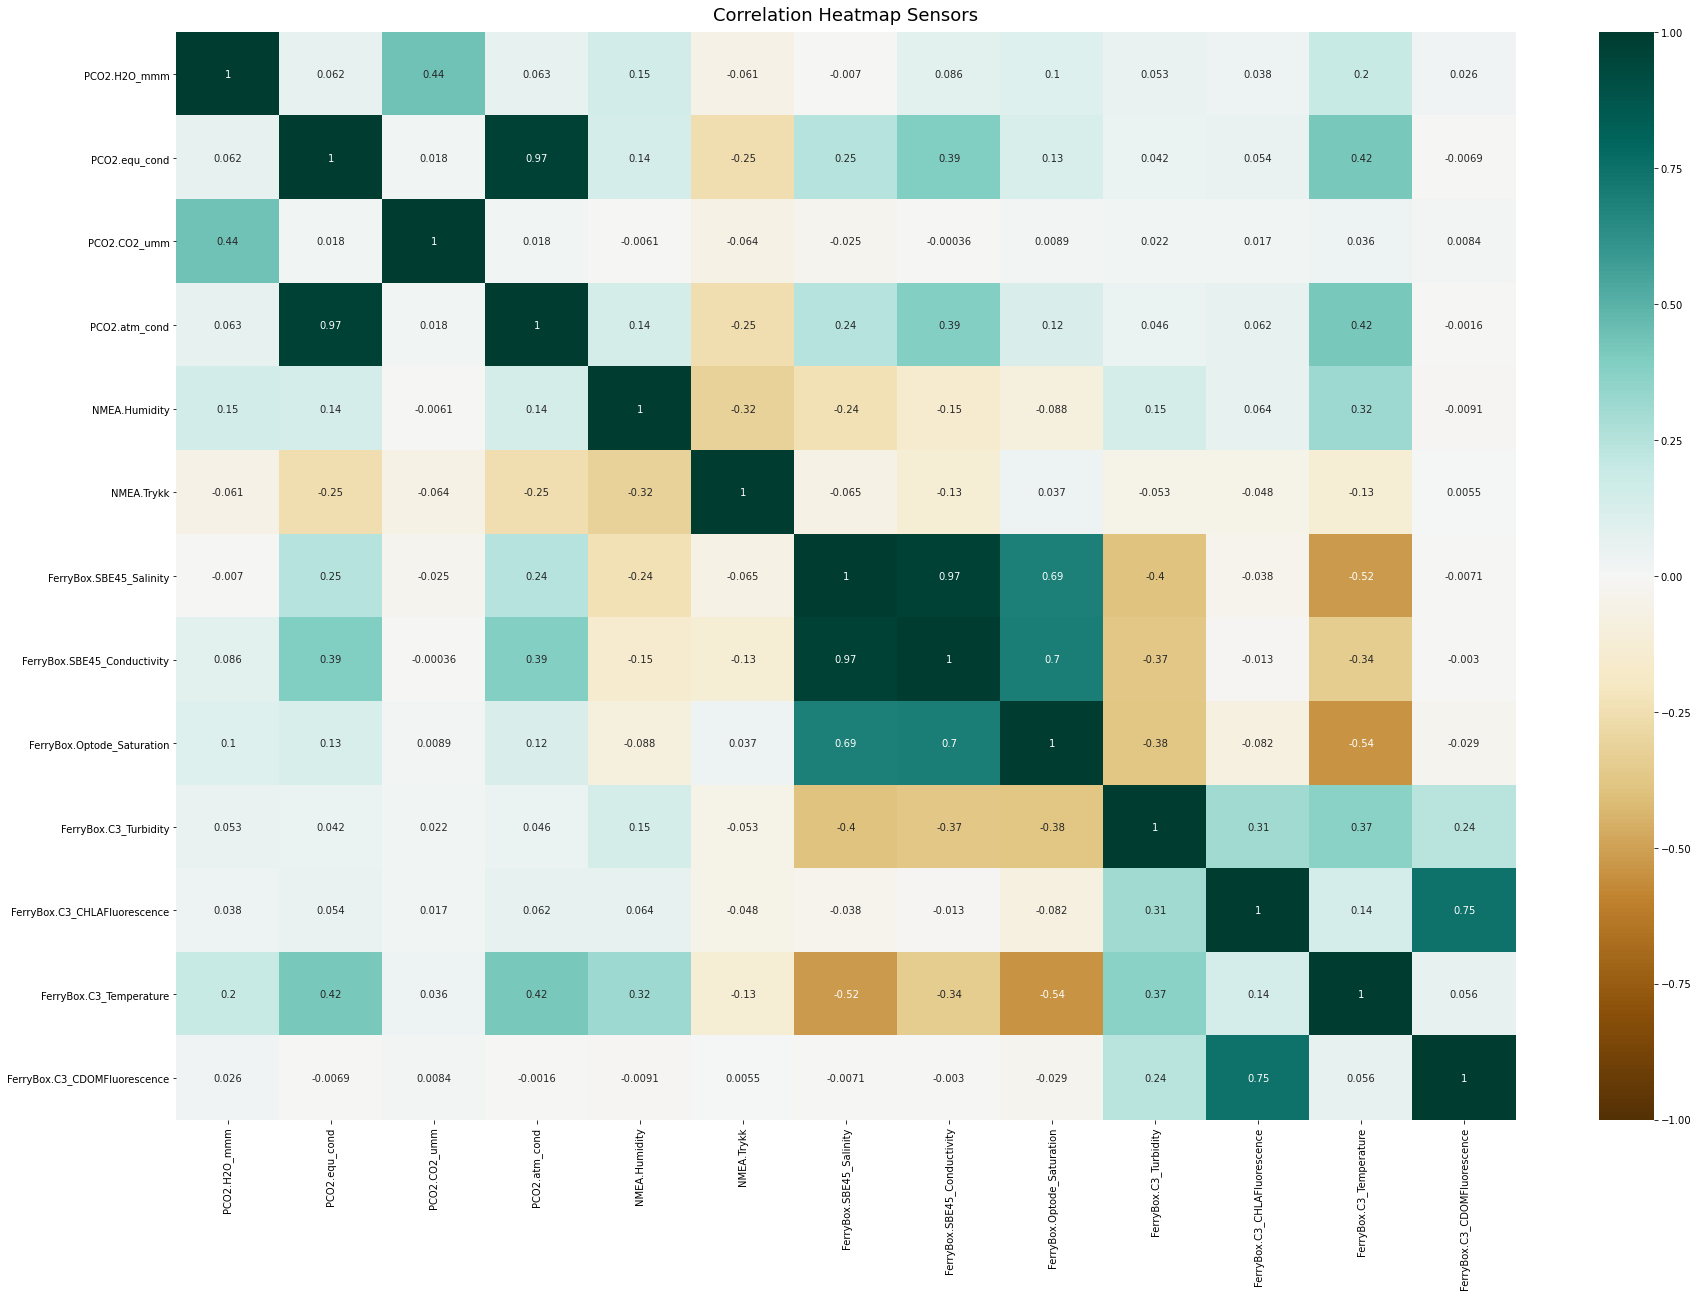

<AxesSubplot:title={'center':'Correlation Heatmap Sensors'}>

In [46]:
corr_matrix(df)